In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import scipy.sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models.phrases import Phrases, Phraser
import gensim.downloader as gensim_api
from tensorflow.keras import preprocessing
from typing import List
import _pickle as pickle

nltk.download("omw-1.4")

FILE_NAME = "covid19_articles_20201231.csv"


[nltk_data] Downloading package omw-1.4 to /Users/sherman/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
STOP_WORDS = set(nltk.corpus.stopwords.words("english"))


def clean_text(text, stemm=False, lemm=True, stopwords=STOP_WORDS):
    text = re.sub(r"[^a-z\s]", "", text.lower().strip())
    if stopwords:
        text = [x for x in text.split() if x not in stopwords]

    if stemm:
        stemmer = PorterStemmer()
        text = [stemmer.stem(x) for x in text]

    if lemm:
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(x) for x in text]

    return " ".join(text)


In [3]:
df = pd.read_csv("data/" + FILE_NAME)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [4]:
df.topic_area.value_counts()

business        244544
general          84923
finance          22389
tech              8676
science           3478
consumer          1451
healthcare        1340
automotive         925
environment        777
construction       305
ai                 239
Name: topic_area, dtype: int64

# Reorganise the topics
Motivation
- AI is a subset of tech
- automotive is kind of a subset of tech
- construction and environment are a subset of science

Need to reduce the number of business, general and finance article to prevent biased models due to thier large size.  

In [5]:
reduced_df = []

df.topic_area = df.topic_area.replace(["ai", "automotive"], "tech")
df.topic_area = df.topic_area.replace(["environment", "construction"], "science")

for topic in df.topic_area.unique():
    _ = df[df.topic_area == topic][["content", "topic_area"]]
    reduced_df.append(_.sample(min(10000, _.shape[0]), random_state=69))

reduced_df = pd.concat(reduced_df)
REDUCED_FILEPATH = "data/" + FILE_NAME.split(".")[0] + "_reduced.csv"
reduced_df.to_csv(REDUCED_FILEPATH)


In [6]:
df = pd.read_csv(REDUCED_FILEPATH)
df.topic_area.value_counts()

business      10000
general       10000
finance       10000
tech           9840
science        4560
consumer       1451
healthcare     1340
Name: topic_area, dtype: int64

In [7]:
## REMOVE THIS LINE FOR PROD ##
## USED FOR TESTING TO MAKE THINGS FASTER ##
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.05, stratify=y, random_state=69
# )
# X = X_test[["content"]]
# y = y_test
# X_train, X_test, y_train, y_test = None, None, None, None
## END ##


In [8]:
df["clean"] = df["content"].apply(
    lambda x: clean_text(x, lemm=True, stopwords=STOP_WORDS)
)


# TFIDF Vectors


In [65]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_features=10000, ngram_range=(1, 2)
)

tfidf_corpus = df["clean"]
tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_vectors.shape)
print(tfidf_corpus.shape)

(47191, 10000)
(47191,)


In [69]:
df.topic_area.unique()

array(['business', 'tech', 'consumer', 'general', 'science', 'finance',
       'healthcare'], dtype=object)

In [71]:
## reduce dimensionality by using Chi-Square test
## generate most significant words
y = df["topic_area"]
tfidf_X_names = tfidf_vectorizer.get_feature_names_out()
p_value_limit = 0.95

_ = pd.DataFrame()
for category in np.unique(y):
    chi_square, p = chi2(tfidf_vectors, y == category)
    _ = pd.concat(
        [_, pd.DataFrame({"feature": tfidf_X_names, "score": 1 - p, "y": category})]
    )
    _ = _.sort_values(["y", "score"], ascending=[True, False])
    _ = _[_["score"] > p_value_limit]

tfidf_X_names = _["feature"].unique().tolist()


In [72]:
## regenerate vectors
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    vocabulary=tfidf_X_names
)

tfidf_corpus = df["clean"]
tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_vectors.shape)


(47191, 6242)


In [73]:
tfidf_df = pd.DataFrame(tfidf_vectors.toarray())
tfidf_df["topic_label"] = y.tolist()
tfidf_df.shape


,0,1,2,3,4,5,6,7,8,9,...,6233,6234,6235,6236,6237,6238,6239,6240,6241,topic_label
0,0.0,0.0,0.0,0.0,0.034418,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,business
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,business
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,business
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.040064,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,business
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,business


In [74]:
## save it for future use
TFIDF_FILEPATH = "processed_data/tfidf_df.csv"
tfidf_df.to_csv(TFIDF_FILEPATH)
tfidf_df = pd.read_csv(TFIDF_FILEPATH)
tfidf_df.shape

TFIDF_VECTORIZER_FILEPATH = "processed_data/tfidf_vectorizer.pkl"
with open(TFIDF_VECTORIZER_FILEPATH, "wb") as f:
    pickle.dump(tfidf_vectorizer, f)


# Word Embeddings (construct our own)

can just use `nlp = gensim_api.load("word2vec-google-news-300")`


In [9]:
we_corpus = df["clean"]

# unigrams
_ = []
for row in we_corpus:
    _.append(row.split())
we_corpus = _

bigram_phraser = Phraser(Phrases(we_corpus, delimiter=" ", min_count=5, threshold=10))



In [21]:
WE_BIGRAM_PHRASER_FILEPATH = "we_bigram_phraser.pkl"
pickle.dump(bigram_phraser, open(WE_BIGRAM_PHRASER_FILEPATH, "wb"))
bigram_phraser = pickle.load(open(WE_BIGRAM_PHRASER_FILEPATH, "rb"))


In [10]:
b_set = set()
for row in we_corpus:
    for word in bigram_phraser[row]:
        if " " in word:
            b_set.add(word)
print(list(b_set)[:10])


['youre basically', 'nasdaq ratio', 'janney montgomery', 'coal miner', 'automated tool', 'borrowing lease', 'trade blacklist', 'certain aspect', 'might occur', 'tension beijing']


In [11]:
VECTOR_SIZE = 300
nlp = gensim.models.word2vec.Word2Vec(
    we_corpus, vector_size=VECTOR_SIZE, window=8, min_count=1, sg=1, epochs=5
)


In [12]:
nlp.wv["former"][:10]

array([ 0.22075476, -0.36148617,  0.02410484, -0.16201712, -0.19490924,
       -0.26607457,  0.35412002,  0.34440163,  0.05011346, -0.0121968 ],
      dtype=float32)

In [13]:
WORD_EMBEDDINGS_FILEPATH = "processed_data/local_word_embeddings.model"
nlp.save(WORD_EMBEDDINGS_FILEPATH)
nlp = gensim.models.Word2Vec.load(WORD_EMBEDDINGS_FILEPATH)
nlp.wv["former"][:10]


array([ 0.22075476, -0.36148617,  0.02410484, -0.16201712, -0.19490924,
       -0.26607457,  0.35412002,  0.34440163,  0.05011346, -0.0121968 ],
      dtype=float32)

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/k3/j42_pl713ll6h7jgr35bjjnr0000gn/T/ipykernel_20403/3116516782.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["input"].iloc[:1] = 1


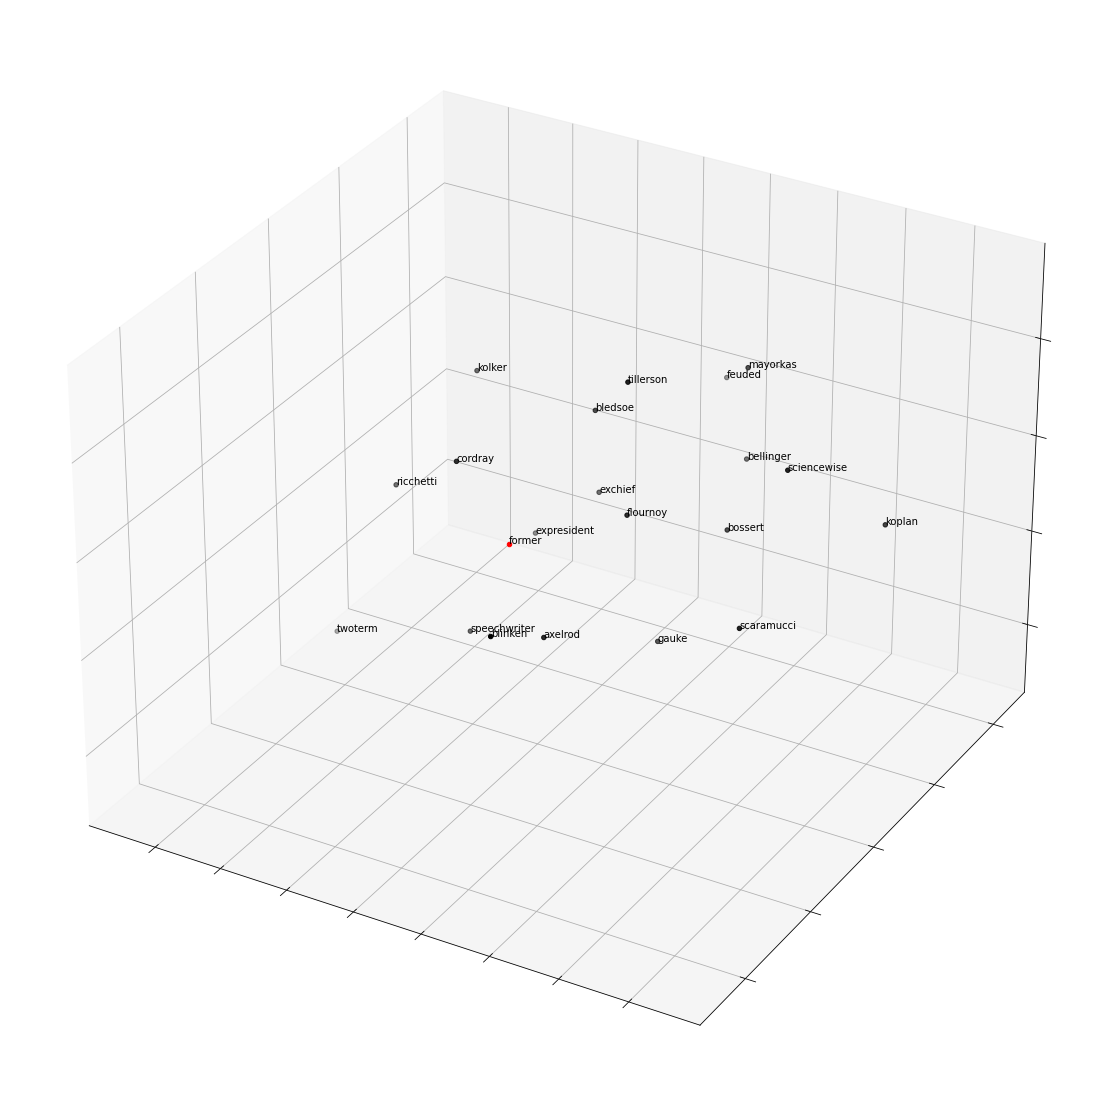

In [14]:
## similar words to "former"
word = "former"
fig = plt.figure(figsize=(20, 20))

total = [word] + [x[0] for x in nlp.wv.most_similar(word, topn=20)]
_ = nlp.wv[total]

pca = manifold.TSNE(init="pca", n_components=3)
_ = pca.fit_transform(_)

_df = pd.DataFrame(_, index=total, columns=["x", "y", "z"])
_df["input"] = 0
_df["input"].iloc[:1] = 1

ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    _df[_df["input"] == 0]["x"],
    _df[_df["input"] == 0]["y"],
    _df[_df["input"] == 0]["z"],
    c="black",
)
ax.scatter(
    _df[_df["input"] == 1]["x"],
    _df[_df["input"] == 1]["y"],
    _df[_df["input"] == 1]["z"],
    c="red",
)
ax.set(
    xlabel=None,
    ylabel=None,
    zlabel=None,
    xticklabels=[],
    yticklabels=[],
    zticklabels=[],
)
for i, row in _df[["x", "y", "z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=i)


In [15]:
## feature engineering
we_corpus = list(bigram_phraser[we_corpus])

tokenizer = preprocessing.text.Tokenizer(
    lower=True,
    split=" ",
    oov_token="NaN",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
)
tokenizer.fit_on_texts(we_corpus)
we_vocab: dict = tokenizer.word_index

we_sequences: List[List[int]] = tokenizer.texts_to_sequences(we_corpus)

we_X = preprocessing.sequence.pad_sequences(
    we_sequences, maxlen=15, padding="post", truncating="post"
)


In [16]:
## create embedding matrix
we_embeddings = np.zeros((len(we_vocab) + 1, VECTOR_SIZE))

for w, i in we_vocab.items():
    if i < len(we_embeddings):
        we_embeddings[i] = nlp.wv[word]


In [17]:
we_embeddings[69]

array([ 2.20754758e-01, -3.61486167e-01,  2.41048448e-02, -1.62017122e-01,
       -1.94909245e-01, -2.66074568e-01,  3.54120016e-01,  3.44401628e-01,
        5.01134619e-02, -1.21967979e-02,  3.77018720e-01,  5.33207357e-02,
        2.17588127e-01,  2.04677418e-01, -2.45643571e-01, -5.64899921e-01,
        4.42337960e-01, -2.62078911e-01, -8.81572664e-02, -2.13324279e-01,
       -2.80341834e-01,  8.14884007e-02,  1.03584059e-01, -1.09895326e-01,
        1.01541504e-01,  4.77366373e-02, -3.73196572e-01,  5.53419031e-02,
        2.62815744e-01, -5.22056036e-02,  9.02309343e-02, -1.43005013e-01,
        4.01975453e-01,  2.27826945e-02,  3.81267667e-01, -7.63364285e-02,
       -1.18307240e-01, -4.39559698e-01, -3.24649632e-01, -9.37923491e-02,
       -3.54229212e-01,  1.55716255e-01,  7.72475600e-02, -3.23536187e-01,
       -3.04452740e-02,  2.16643527e-01,  3.13095860e-02,  6.92812279e-02,
        3.31363007e-02,  3.77680033e-01,  1.31314874e-01,  2.02142164e-01,
        9.68949124e-02,  

In [18]:
WE_FILEPATH = "processed_data/word_embeddings"
np.save(WE_FILEPATH, we_embeddings)
we_embeddings = np.load(WE_FILEPATH + ".npy")
we_embeddings[69]


array([ 2.20754758e-01, -3.61486167e-01,  2.41048448e-02, -1.62017122e-01,
       -1.94909245e-01, -2.66074568e-01,  3.54120016e-01,  3.44401628e-01,
        5.01134619e-02, -1.21967979e-02,  3.77018720e-01,  5.33207357e-02,
        2.17588127e-01,  2.04677418e-01, -2.45643571e-01, -5.64899921e-01,
        4.42337960e-01, -2.62078911e-01, -8.81572664e-02, -2.13324279e-01,
       -2.80341834e-01,  8.14884007e-02,  1.03584059e-01, -1.09895326e-01,
        1.01541504e-01,  4.77366373e-02, -3.73196572e-01,  5.53419031e-02,
        2.62815744e-01, -5.22056036e-02,  9.02309343e-02, -1.43005013e-01,
        4.01975453e-01,  2.27826945e-02,  3.81267667e-01, -7.63364285e-02,
       -1.18307240e-01, -4.39559698e-01, -3.24649632e-01, -9.37923491e-02,
       -3.54229212e-01,  1.55716255e-01,  7.72475600e-02, -3.23536187e-01,
       -3.04452740e-02,  2.16643527e-01,  3.13095860e-02,  6.92812279e-02,
        3.31363007e-02,  3.77680033e-01,  1.31314874e-01,  2.02142164e-01,
        9.68949124e-02,  